In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']

In [2]:
from scipy.stats import kendalltau, spearmanr

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 13)


In [3]:
from plot_tss_results import helper_save

In [4]:
data_dir = "Results/Figures/SuppFigure_expCompare"
out_dir = "Results/Figures/12032019/SuppFigure_expCompare"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Different examples:
Samples:  
1. CHO GRO-cap both samples and csRNA   
2. Brain GRO-cap and csRNA both samples  

Regions:  
1. Final promoter peaks
2. All peaks found in the respective sample  
3. Only peaks found in both samples



# A.

## In order to ensure that GRO-Cap and csRNA gave similar results, we looked to see how far apart peaks found within the same 150 nts were. This helps determine if the TSSs captured from the different experiments are slightly shifted. 


# 1. CHO

In [5]:
# 1. CHO samples around promoter peaks
# GROcap vs START
peaks = "Results/output/TSS1.exp.bed"

t = "CHO"

s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
s = "START"
f2 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*START1",
))

out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f2[0]))

cmd = "annotatePeaks.pl {peak_f} {ref} -size 150 -log -norm 1e6 -d {f1} {f2} > {out_f}".format(
    peak_f=peaks, ref=ref_fa, f1=f1[0], f2=f2[0], out_f=out_f)

print(cmd)
!{cmd}

annotatePeaks.pl Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 150 -log -norm 1e6 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/START/f03_tags/trim_CHO_START1 > Results/Figures/12032019/SuppFigure_expCompare/CHO_trim_CHO_GROCap1_trim_CHO_START1

	Using Custom Genome
	Peak file = Results/output/TSS1.exp.bed
	Genome = GCF_003668045.1_CriGri-PICR_genomic.fna
	Organism = unknown
	Peak Region set to 150
	Will output log(1+rand()+x) for tag counts
	Will normalize tag counts to 1e6 per experiment
	Tag Directories:
		/data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1
		/data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/START/f03_tags/trim_CHO_START1
	Peak/BED file conversion summary:
		BED/Header formatted lines: 30775
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 30775
		Redu

KendalltauResult(correlation=0.6345746633691216, pvalue=0.0)
SpearmanrResult(correlation=0.8194976284541597, pvalue=0.0)


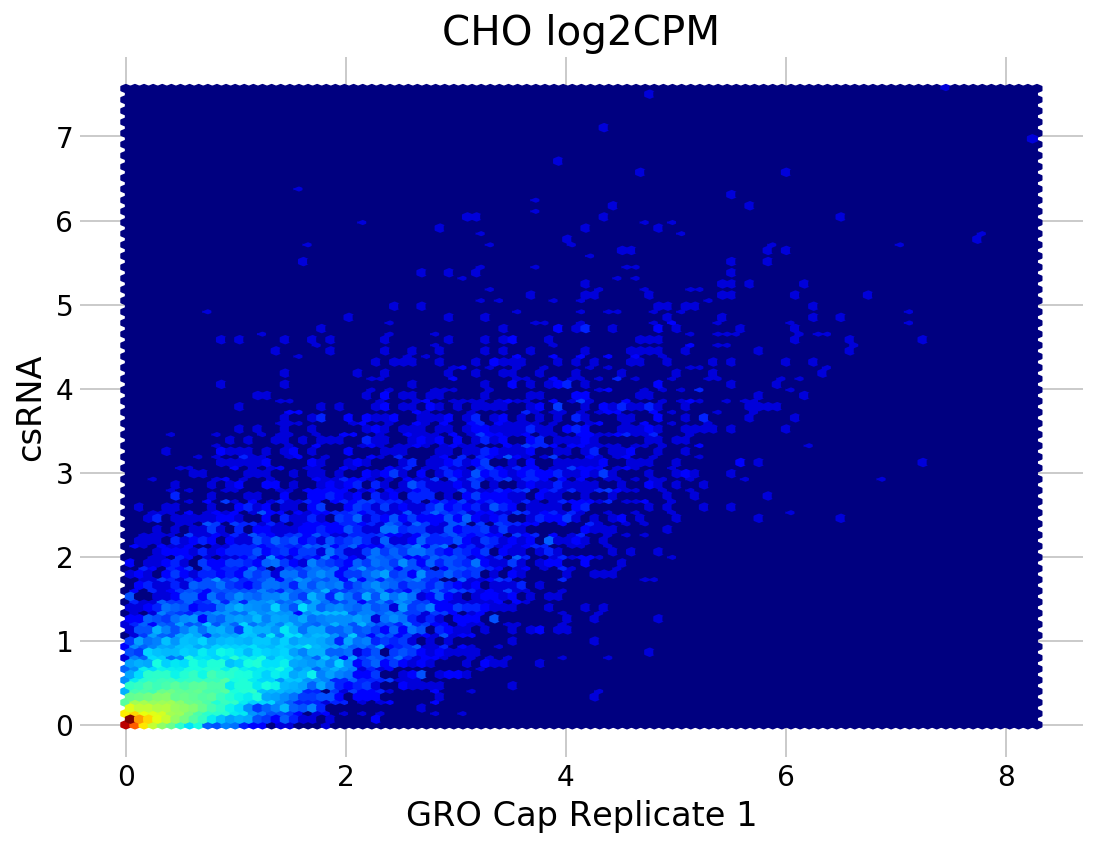

In [7]:
# 1. CHO samples around promoter peaks
# GROcap vs START
peaks = "Results/output/TSS1.exp.bed"

t = "CHO"

s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
s = "START"
f2 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*START1",
))

out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f2[0]))
df_gro_start = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df_gro_start.columns.values
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f2[0]).replace("trim_","")
df_gro_start.columns = cols

# g = sns.jointplot(x=cols[-2],y=cols[-1],data=df_gro_start)#, kind="hex")

# g = sns.jointplot(x=cols[-2],y=cols[-1],data=df_gro_start[(df_gro_start[cols[-1]]>1) | (df_gro_start[cols[-2]]>1)], kind="hex")


f = plt.figure()
plt.hexbin(x=cols[-2],y=cols[-1],data=df_gro_start, cmap=plt.cm.jet, bins='log')


# f = plt.figure()
# plt.hexbin(x=cols[-2],y=cols[-1],data=df_gro_start[(df_gro_start[cols[-1]]>1) | (df_gro_start[cols[-2]]>1)])

#g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
#helper_save("Results/Figures/SuppFigure_expCompare/CHO_reps_grocap_csrna")

plt.xlabel("GRO Cap Replicate 1")#cols[-2].split("_")[-1])
plt.ylabel("csRNA")#plt.ylabel(cols[-1].split("_")[-1])

plt.title("CHO log2CPM")

#filt_df = df_gro_start[(df_gro_start[cols[-1]]>1) | (df_gro_start[cols[-2]]>1)]

print(kendalltau(df_gro_start[cols[-1]], df_gro_start[cols[-2]]))
#print(kendalltau(filt_df[cols[-1]], filt_df[cols[-2]]))

print(spearmanr(df_gro_start[cols[-1]], df_gro_start[cols[-2]]))
#print(spearmanr(filt_df[cols[-1]], filt_df[cols[-2]]))
helper_save(os.path.join(out_dir,"CHO_reps_grocap_csrna"))

### CHO GROCap Replicates

In [8]:
# 1. CHO samples around promoter peaks
# GROcap vs GROcap
peaks = "Results/output/TSS1.exp.bed"

t = "CHO"
s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f1[1]))
cmd = "annotatePeaks.pl {peak_f} {ref} -size 150 -log -norm 1e6 -d {f1} {f1_1} > {out_f}".format(
    peak_f=peaks, ref=ref_fa, f1=f1[0], f1_1=f1[1], out_f=out_f)

print(cmd)
!{cmd}

annotatePeaks.pl Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 150 -log -norm 1e6 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap2 > Results/Figures/12032019/SuppFigure_expCompare/CHO_trim_CHO_GROCap1_trim_CHO_GROCap2

	Using Custom Genome
	Peak file = Results/output/TSS1.exp.bed
	Genome = GCF_003668045.1_CriGri-PICR_genomic.fna
	Organism = unknown
	Peak Region set to 150
	Will output log(1+rand()+x) for tag counts
	Will normalize tag counts to 1e6 per experiment
	Tag Directories:
		/data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1
		/data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap2
	Peak/BED file conversion summary:
		BED/Header formatted lines: 30775
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 30775
	

KendalltauResult(correlation=0.7324824767729792, pvalue=0.0)
KendalltauResult(correlation=0.7021835340089161, pvalue=0.0)
SpearmanrResult(correlation=0.8865463370896434, pvalue=0.0)
SpearmanrResult(correlation=0.8775013420921423, pvalue=0.0)


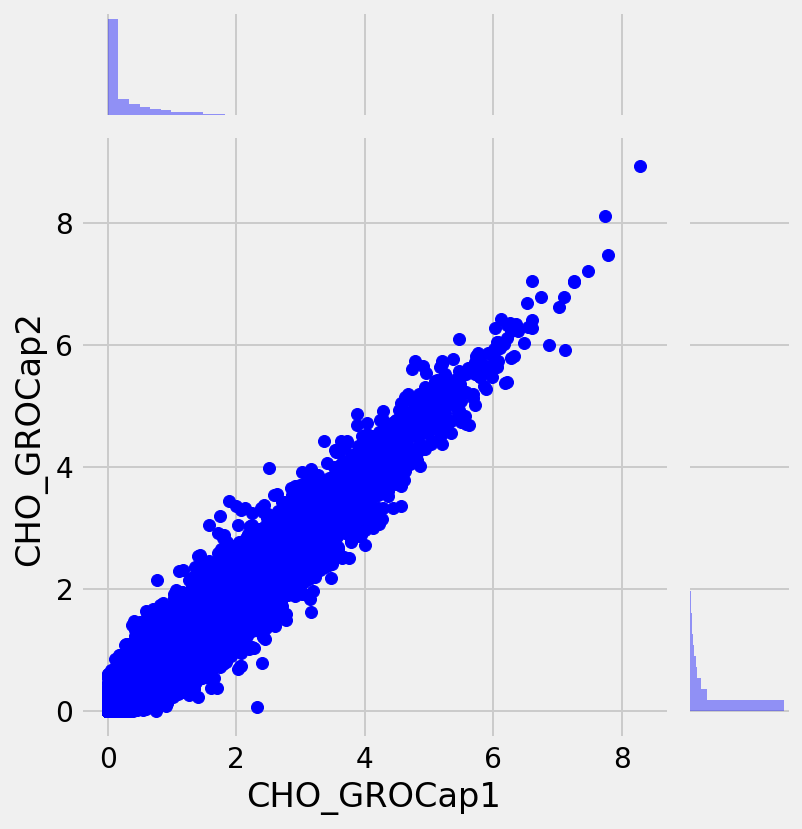

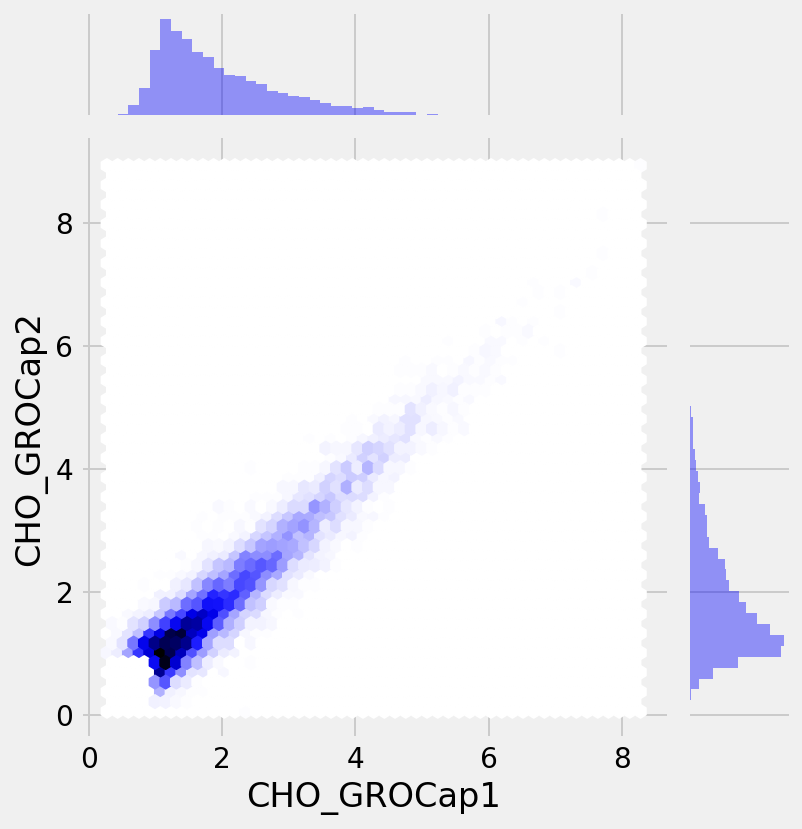

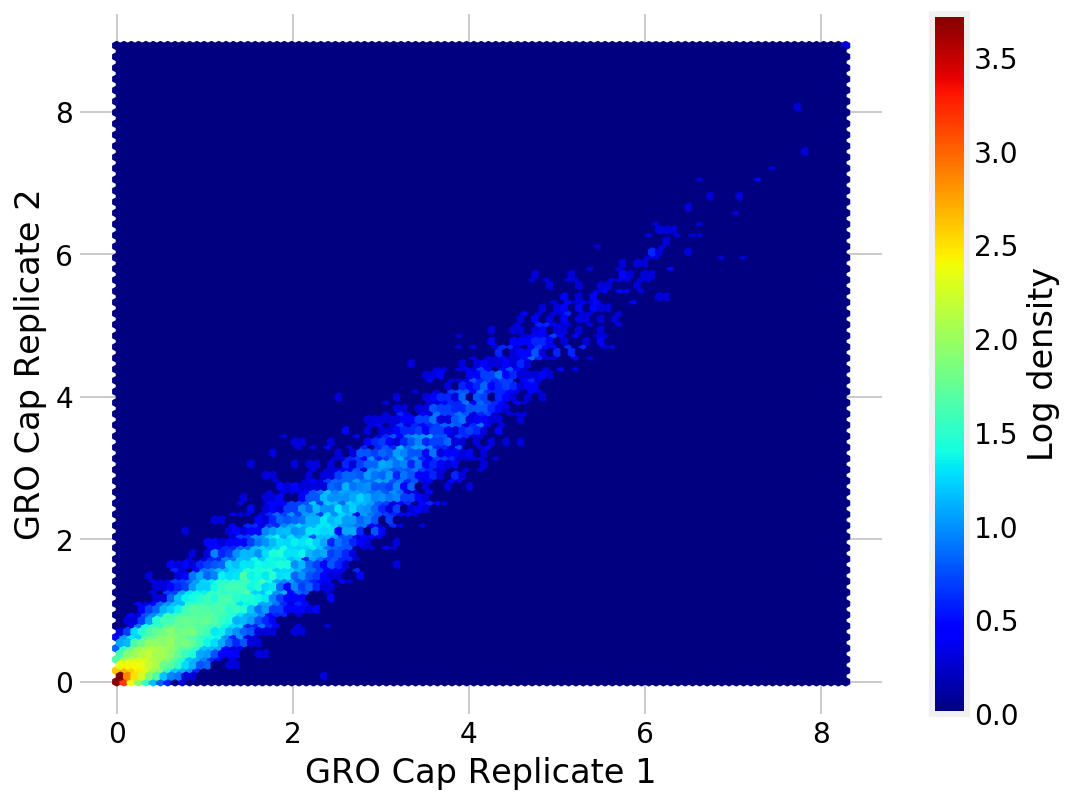

In [9]:
peaks = "Results/output/TSS1.exp.bed"

t = "CHO"
s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f1[1]))

df_gro_gro = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df_gro_gro.columns.values
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f1[1]).replace("trim_","")
df_gro_gro.columns = cols
sns.jointplot(x=cols[-2],y=cols[-1],data=df_gro_gro)

g = sns.jointplot(x=cols[-2],y=cols[-1],data=df_gro_gro[(df_gro_gro[cols[-1]]>1) | (df_gro_gro[cols[-2]]>1)], kind="hex")


f = plt.figure()
plt.hexbin(x=cols[-2],y=cols[-1],data=df_gro_gro, cmap=plt.cm.jet, bins='log')
plt.colorbar().set_label("Log density")
plt.xlabel("GRO Cap Replicate 1") #cols[-2].split("_")[-1])
plt.ylabel("GRO Cap Replicate 2") #plt.ylabel(cols[-1].split("_")[-1])
helper_save(os.path.join(out_dir,"CHO_reps_grocap"))


# f = plt.figure()
# plt.hexbin(x=cols[-2],y=cols[-1],data=df_gro_gro[(df_gro_gro[cols[-1]]>1) | (df_gro_gro[cols[-2]]>1)])


filt_df = df_gro_gro[(df_gro_gro[cols[-1]]>1) | (df_gro_gro[cols[-2]]>1)]
print(kendalltau(df_gro_gro[cols[-1]], df_gro_gro[cols[-2]]))
print(kendalltau(filt_df[cols[-1]], filt_df[cols[-2]]))

print(spearmanr(df_gro_gro[cols[-1]], df_gro_gro[cols[-2]]))
print(spearmanr(filt_df[cols[-1]], filt_df[cols[-2]]))



## Subplots (figure that goes in paper)

SpearmanrResult(correlation=0.8194976284541597, pvalue=0.0)
('GRO Replicates: ', (0.9737841323506745, 0.0))
('GRO csRNA', (0.8489837632046211, 0.0))
SpearmanrResult(correlation=0.8194976284541597, pvalue=0.0)
SpearmanrResult(correlation=0.8865463370896434, pvalue=0.0)


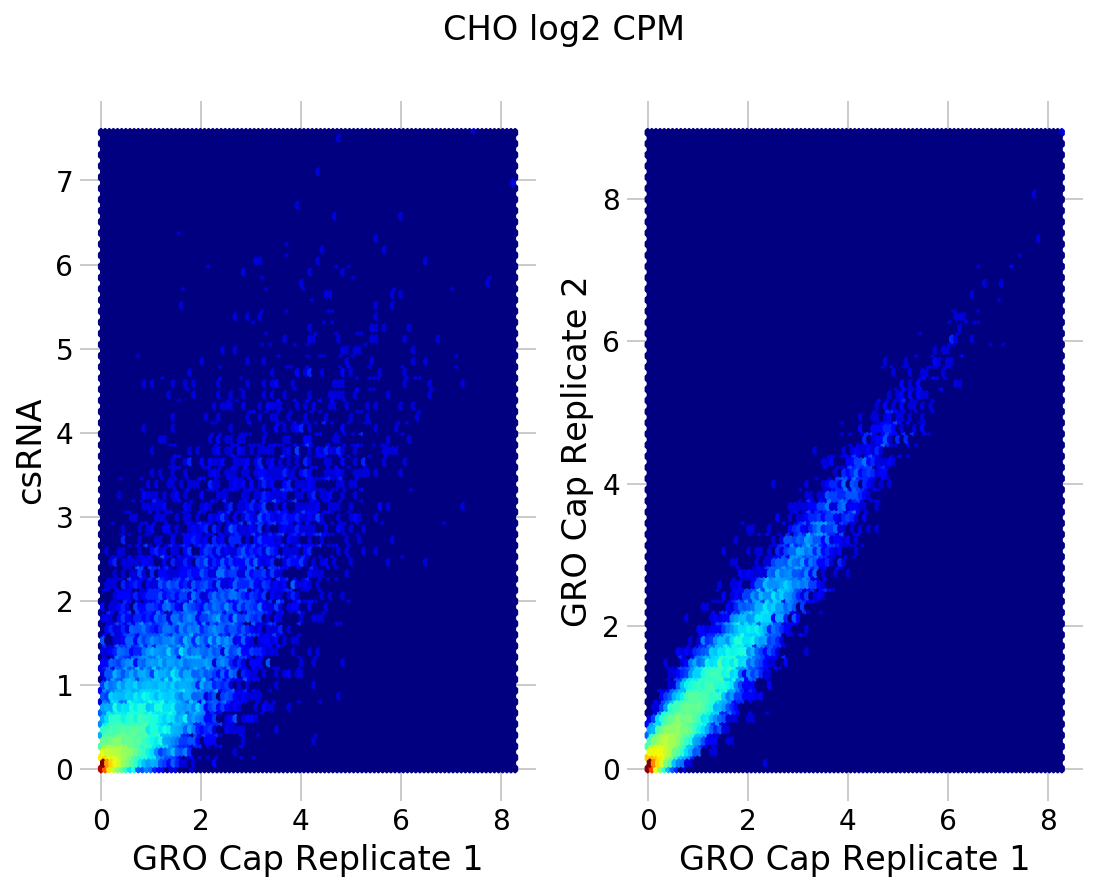

In [10]:
# 1. CHO samples around promoter peaks
# GROcap vs START
peaks = "Results/output/TSS1.exp.bed"

t = "CHO"

s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
s = "START"
f2 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*START1",
))

out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f2[0]))
df_gro_start = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df_gro_start.columns.values
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f2[0]).replace("trim_","")
df_gro_start.columns = cols


f, ax = plt.subplots(nrows=1,ncols=2)
ax[0].hexbin(x=cols[-2],y=cols[-1],data=df_gro_start, cmap=plt.cm.jet, bins='log')
ax[0].set_xlabel("GRO Cap Replicate 1")#cols[-2].split("_")[-1])
ax[0].set_ylabel("csRNA")#plt.ylabel(cols[-1].split("_")[-1])
#plt.title("CHO log2CPM")
corr_gro_cs = spearmanr(df_gro_start[cols[-1]], df_gro_start[cols[-2]])
print(spearmanr(df_gro_start[cols[-1]], df_gro_start[cols[-2]]))

# GROCap replicates
peaks = "Results/output/TSS1.exp.bed"
t = "CHO"
s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))
out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f1[1]))
df_gro_gro = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df_gro_gro.columns.values
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f1[1]).replace("trim_","")
df_gro_gro.columns = cols
corr_gro_gro = spearmanr(df_gro_gro[cols[-1]], df_gro_gro[cols[-2]])

ax[1].hexbin(x=cols[-2],y=cols[-1],data=df_gro_gro, cmap=plt.cm.jet, bins='log')
#ax[1].colorbar().set_label("Log density")
ax[1].set_xlabel("GRO Cap Replicate 1") #cols[-2].split("_")[-1])
ax[1].set_ylabel("GRO Cap Replicate 2") #plt.ylabel(cols[-1].split("_")[-1])
plt.suptitle("CHO log2 CPM")
helper_save(os.path.join(out_dir,"CHO_reps_scatter"))

from scipy.stats import  pearsonr

print("GRO Replicates: ", pearsonr(df_gro_gro[cols[-1]], df_gro_gro[cols[-2]]))
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f2[0]).replace("trim_","")
print("GRO csRNA", pearsonr(df_gro_start[cols[-1]], df_gro_start[cols[-2]]))


print(corr_gro_cs)
print(corr_gro_gro)

Text(0.5,0,u'CHO GRO Cap1 log2 CPM')

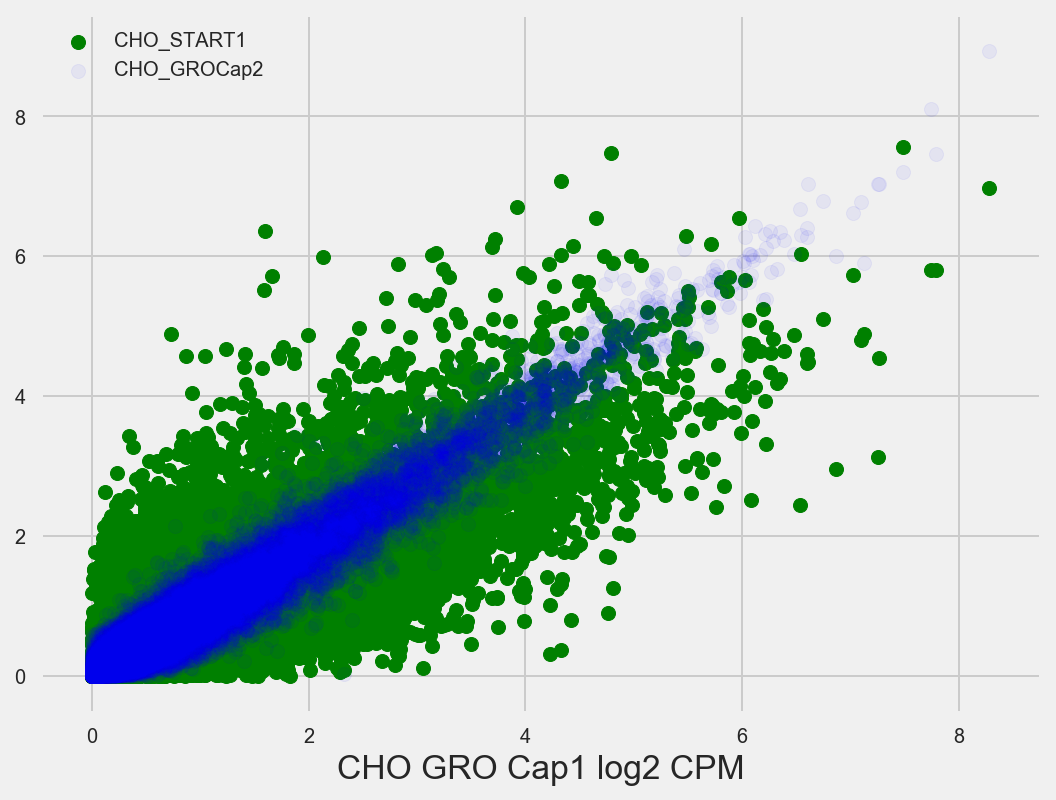

In [19]:
plt.scatter(df_gro_start["CHO_GROCap1"],df_gro_start["CHO_START1"],color="g")
plt.scatter(df_gro_gro["CHO_GROCap1"],df_gro_gro["CHO_GROCap2"],alpha=0.05)
plt.legend()

plt.xlabel("CHO GRO Cap1 log2 CPM")

# 2. Brain

annotatePeaks.pl Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 150 -log -d /data/isshamie/TSS/NCBI_PICR_103_Processed/Brain/GROCap/f03_tags/trim_Brain_GROCap1 /data/isshamie/TSS/NCBI_PICR_103_Processed/Brain/START/f03_tags/trim_Brain_START3 > Results/Figures/SuppFigure_expCompare/Brain_trim_Brain_GROCap1_trim_Brain_START3

	Using Custom Genome
	Peak file = Results/output/TSS1.exp.bed
	Genome = GCF_003668045.1_CriGri-PICR_genomic.fna
	Organism = unknown
	Peak Region set to 150
	Will output log(1+rand()+x) for tag counts
	Tag Directories:
		/data/isshamie/TSS/NCBI_PICR_103_Processed/Brain/GROCap/f03_tags/trim_Brain_GROCap1
		/data/isshamie/TSS/NCBI_PICR_103_Processed/Brain/START/f03_tags/trim_Brain_START3
	Peak/BED file conversion summary:
		BED/Header formatted lines: 30775
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 30775
		Redundant Peak IDs: 0
		Peaks lacking information:

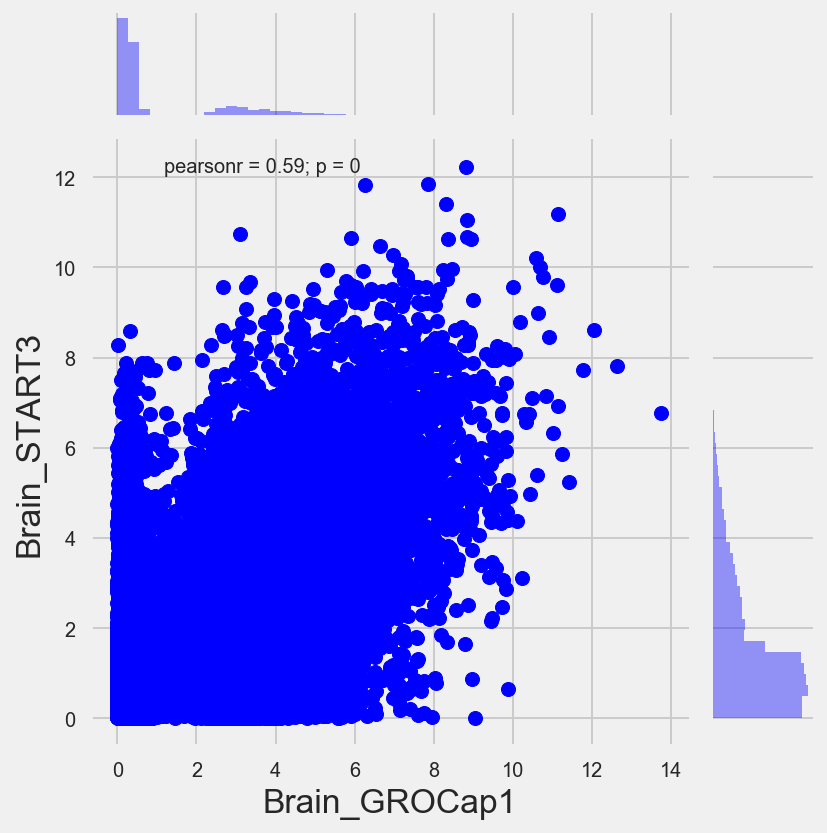

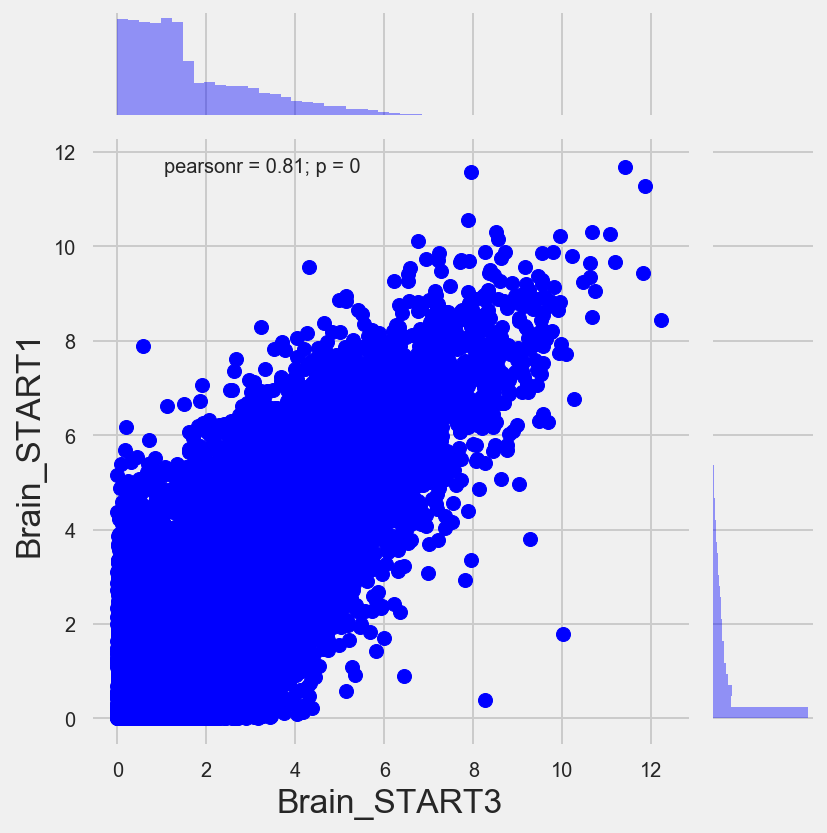

In [147]:
# 1. Brain samples around promoter peaks
# GROcap vs START
peaks = "Results/output/TSS1.exp.bed"

t = "Brain"

s = "GROCap"
f1 = glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*GROCap*",
))

s = "START"
f2 = np.array(glob.glob(os.path.join(
    data_folder,
    t,
    s,
    "f03_tags/trim*START*",
)))

f2 = f2[np.flatnonzero(np.array(map(lambda x: "input" not in x, np.array(f2))))]
f2


out_f = os.path.join(out_dir, t + "_" + os.path.basename(f1[0]) + "_" + os.path.basename(f2[0]))

cmd = "annotatePeaks.pl {peak_f} {ref} -size 150 -log -d {f1} {f2} > {out_f}".format(
    peak_f=peaks, ref=ref_fa, f1=f1[0], f2=f2[0], out_f=out_f)

print(cmd)
!{cmd}

df = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df.columns.values
cols[-2] = os.path.basename(f1[0]).replace("trim_","")
cols[-1] = os.path.basename(f2[0]).replace("trim_","")
df.columns = cols
sns.jointplot(x=cols[-2],y=cols[-1],data=df)

# 1. Brain samples around promoter peaks
# csRNA vs csRNA
out_f = os.path.join(out_dir, t + "_" + os.path.basename(f2[0]) + "_" + os.path.basename(f2[1]))
cmd = "annotatePeaks.pl {peak_f} {ref} -size 150 -log -norm 1e6 -d {f2} {f2_1} > {out_f}".format(
    peak_f=peaks, ref=ref_fa, f2=f2[0], f2_1=f2[1], out_f=out_f)

print(cmd)
!{cmd}

df = pd.read_csv(out_f, sep="\t",index_col=0)
cols = df.columns.values
cols[-2] = os.path.basename(f2[0]).replace("trim_","")
cols[-1] = os.path.basename(f2[1]).replace("trim_","")
df.columns = cols
sns.jointplot(x=cols[-2],y=cols[-1],data=df)